In [1]:
import numpy as np
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from matplotlib.ticker import ScalarFormatter

In [2]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

## Palmer, Huk, and Shadlen (2005) The effect of stimulus strength on the speed and accuracy of a perceptual decision

In [3]:
def make_palmer_dataframe():
    # convert original matlab files from Palmer et al 2005 into a single pandas dataframe
    names = ['JP', 'AH']
    dfs = []
    for i, filename in enumerate(['data/e12jp_bytrial.mat', 'data/e12ah_bytrial.mat']):
        f = scipy.io.loadmat(filename)
        emp = f['Data']
        df = pd.DataFrame({
                'name': [names[i] for j in range(len(emp[:,0]))],
                'trial': emp[:,7-1],
                'coherence': emp[:,22-1]/10,
                'goodtrial': emp[:,20-1],
                'accuracy': emp[:,14-1]*100,
                'RT': emp[:,15-1]/1000,
                'condition': emp[:,26-1]
            })
        data = df.query("goodtrial==1")
        data.loc[data["condition"] == 1.0, "condition"] = "speed"
        data.loc[data["condition"] == 2.0, "condition"] = "normal"
        data.loc[data["condition"] == 3.0, "condition"] = "accuracy"
        dfs.append(data)
    palmer = pd.concat(dfs, ignore_index=True)
    palmer = palmer.drop(columns=['goodtrial'])
    palmer.to_pickle("data/palmer2005.pkl")
    return palmer
# palmer = make_palmer_dataframe()
# print(palmer)

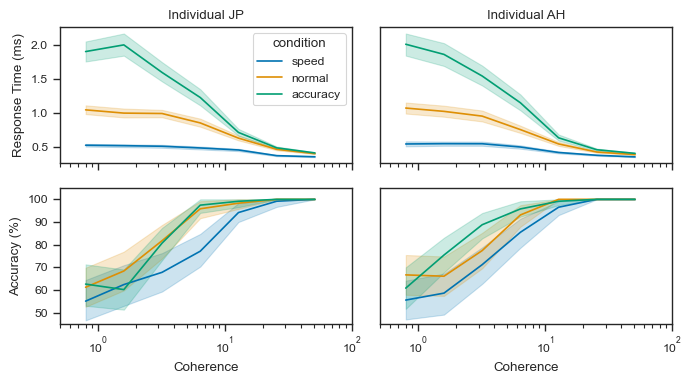

In [4]:
def plot_palmer():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='RT', hue='condition', palette=palette[:3], ax=axes[0][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='RT', hue='condition', palette=palette[:3], ax=axes[0][1])
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='accuracy', hue='condition', palette=palette[:3], ax=axes[1][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='accuracy', hue='condition', palette=palette[:3], ax=axes[1][1])
    axes[0][0].set_xscale('log')
    axes[0][0].set(ylabel="Response Time (ms)", title="Individual JP")
    axes[0][1].set(ylabel=None, yticks=(()), title="Individual AH")
    axes[1][0].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1][1].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=(()))
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/palmer2005.svg")
    fig.savefig(f"plots/palmer2005.png", dpi=600)
plot_palmer()

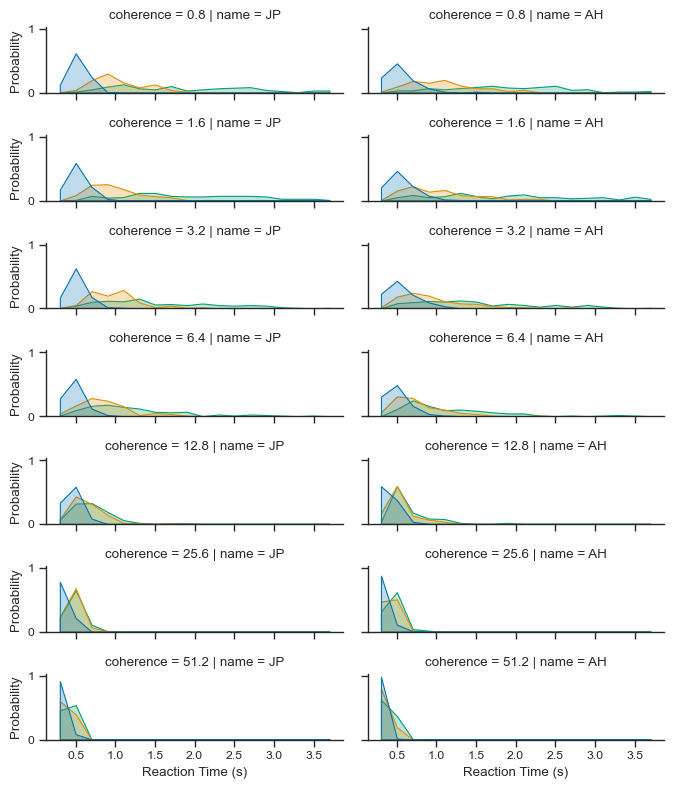

In [5]:
def plot_palmer2():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    coherences = np.sort(palmer['coherence'].unique())
    fig = sns.FacetGrid(palmer, col="name",  row="coherence", height=1.15, aspect=3)
    fig.map_dataframe(sns.histplot, x="RT", stat='probability', bins=np.arange(0.2, 4, 0.2), element="poly", hue="condition", common_norm=False, palette=palette[:3])
    fig.set_xlabels("Reaction Time (s)")
    fig.savefig(f"plots/palmer2005_distributions.svg")
    fig.savefig(f"plots/palmer2005_distributions.png", dpi=600)
plot_palmer2()

## Churchland, Kiani, and Shadlen (2008) Decision-making with multiple alternatives

In [51]:
def make_churchland_firing_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'trial', 'neuron', 'RT', 'accuracy', 'time', 'firing rate')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times
    pref = 1  # preferred direction 

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            nCoherences = len(emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'])
            for c in range(nCoherences):
                # select preferred direction (pref) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                dat = emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    if type(dat[trial]['rt'])!=float: continue
                    RT = int(dat[trial]['rt'])
                    coherence = float(dat[trial]['coh']) / 10
                    spike_times = dat[trial]['dots']
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(spike_times)!=np.ndarray or len(spike_times)==0:  continue  # skip empty data
                    spike_times = np.array(dat[trial]['dots']).astype(int)  # remove sub-ms precision in spike times
                    tstart = spike_times[0]
                    tend = spike_times[-1]+1
                    times = np.arange(tstart, tend)  # time relative to stimulus onset
                    spike_array = np.zeros_like(times)
                    spike_array[spike_times-tstart] = 1  # put a value of 1 at the index of every spike time
                    firing_rates = filter.filt(1000*spike_array)  # compute firing rate in spikes/second (Hz) by filtering with lowpass filter
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=100/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    df = pd.DataFrame()
                    df['nActions'] = nActions*np.ones_like(times)
                    df['coherence'] = coherence*np.ones_like(times)
                    df['trial'] = trial*np.ones_like(times)
                    df['neuron'] = neuron*np.ones_like(times)
                    df['RT'] = RT*np.ones_like(times)
                    df['accuracy'] = accuracy*np.ones_like(times)
                    df['nActions'] = nActions*np.ones_like(times)
                    df['time'] = times
                    df['firing rate'] = firing_rates
                    dfs.append(df)

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_firing.pkl")
    return churchland

churchland_firing = make_churchland_firing_dataframe()

neuron 0, nActions 2, coherence 0.0, trial 0
neuron 0, nActions 2, coherence 0.0, trial 1
neuron 0, nActions 2, coherence 0.0, trial 2
neuron 0, nActions 2, coherence 0.0, trial 3
neuron 0, nActions 2, coherence 0.0, trial 4
neuron 0, nActions 2, coherence 0.0, trial 5
neuron 0, nActions 2, coherence 0.0, trial 6
neuron 0, nActions 2, coherence 0.0, trial 7
neuron 0, nActions 2, coherence 0.0, trial 8
neuron 0, nActions 2, coherence 0.0, trial 9
neuron 0, nActions 2, coherence 0.0, trial 10
neuron 0, nActions 2, coherence 0.0, trial 11
neuron 0, nActions 2, coherence 0.0, trial 12
neuron 0, nActions 2, coherence 0.0, trial 13
neuron 0, nActions 2, coherence 0.0, trial 14
neuron 0, nActions 2, coherence 0.0, trial 15
neuron 0, nActions 2, coherence 0.0, trial 16
neuron 0, nActions 2, coherence 0.0, trial 17
neuron 0, nActions 2, coherence 0.0, trial 18
neuron 0, nActions 2, coherence 0.0, trial 19
neuron 0, nActions 2, coherence 0.0, trial 20
neuron 0, nActions 2, coherence 0.0, trial 2

In [52]:
churchland_firing

nActions  coherence  trial  neuron   RT  accuracy  time  firing rate
0                2        0.0      0       0  720      50.0 -1129    32.783900
1                2        0.0      0       0  720      50.0 -1128    31.709115
2                2        0.0      0       0  720      50.0 -1127    30.669567
3                2        0.0      0       0  720      50.0 -1126    29.664099
4                2        0.0      0       0  720      50.0 -1125    28.691594
...            ...        ...    ...     ...  ...       ...   ...          ...
44104354         4       72.4     27      74  466     100.0   538    22.266389
44104355         4       72.4     27      74  466     100.0   539    21.536410
44104356         4       72.4     27      74  466     100.0   540    20.830362
44104357         4       72.4     27      74  466     100.0   541    20.147462
44104358         4       72.4     27      74  466     100.0   542    52.270849

[44104359 rows x 8 columns]

In [15]:
def make_churchland_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'RT', 'accuracy')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            for c, coherence in enumerate(coherences):
                # select preferred direction (0) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                if c >= len(emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time']): continue  # empty data
                dat = emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(dat[trial]['rt']) != float: continue  # empty data, skip
                    RT = int(dat[trial]['rt'])
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=1/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    dfs.append(pd.DataFrame([[nActions, 100*coherence, RT, accuracy]], columns=columns))

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_behavior.pkl")
    return churchland

churchland_behavior = make_churchland_behavior_dataframe()

neuron 0, nActions 2, coherence 0.0, trial 0
neuron 0, nActions 2, coherence 0.0, trial 1
neuron 0, nActions 2, coherence 0.0, trial 2
neuron 0, nActions 2, coherence 0.0, trial 3
neuron 0, nActions 2, coherence 0.0, trial 4
neuron 0, nActions 2, coherence 0.0, trial 5
neuron 0, nActions 2, coherence 0.0, trial 6
neuron 0, nActions 2, coherence 0.0, trial 7
neuron 0, nActions 2, coherence 0.0, trial 8
neuron 0, nActions 2, coherence 0.0, trial 9
neuron 0, nActions 2, coherence 0.0, trial 10
neuron 0, nActions 2, coherence 0.0, trial 11
neuron 0, nActions 2, coherence 0.0, trial 12
neuron 0, nActions 2, coherence 0.0, trial 13
neuron 0, nActions 2, coherence 0.0, trial 14
neuron 0, nActions 2, coherence 0.0, trial 15
neuron 0, nActions 2, coherence 0.0, trial 16
neuron 0, nActions 2, coherence 0.0, trial 17
neuron 0, nActions 2, coherence 0.0, trial 18
neuron 0, nActions 2, coherence 0.0, trial 19
neuron 0, nActions 2, coherence 0.0, trial 20
neuron 0, nActions 2, coherence 0.0, trial 2

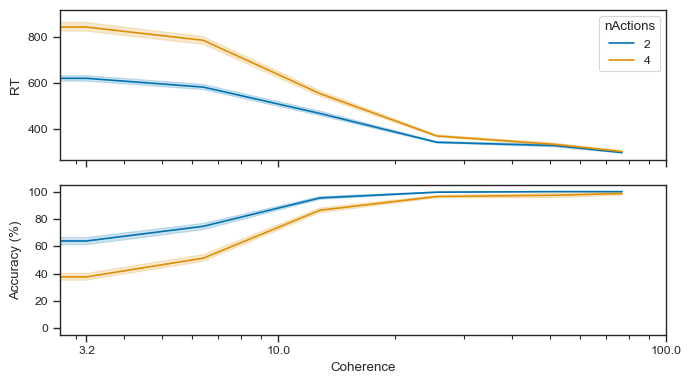

In [27]:
def plot_churchland_behavior():
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=churchland_behavior, x='coherence', y='RT', hue="nActions", palette=palette[:2], ax=axes[0])
    sns.lineplot(data=churchland_behavior, x='coherence', y='accuracy', hue="nActions", palette=palette[:2], ax=axes[1])
    # axes[1].set_xscale('log')
    # axes[1].set_xticks([20, 200, 500])
    axes[1].set(xscale='log', xticks=[3.2, 10, 100], xlabel='Coherence', ylabel='Accuracy (%)')
    # axes[1].set(xscale='log', xticks=[3.2,  6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland2008_behavior.svg")
    fig.savefig(f"plots/churchland2008_behavior.png", dpi=600)
plot_churchland_behavior()

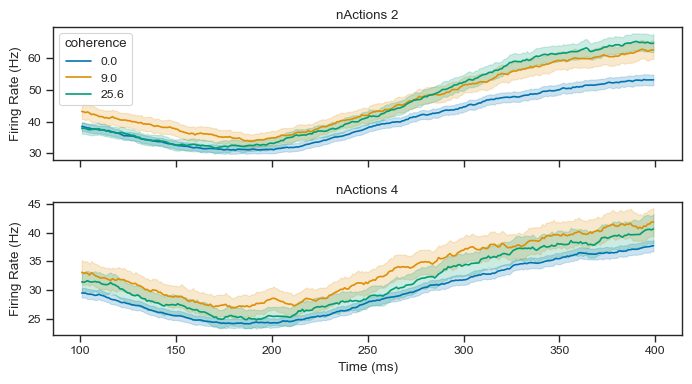

In [54]:
def plot_churchland_rates(tmin=100, tmax=400):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    # coherences = churchland['coherence'].unique()
    coherences = [0.0, 9.0, 25.6]
    subdata = churchland.query("nActions==2 & time>@tmin & time<@tmax & coherence in @coherences")
    subdata2 = churchland.query("nActions==4 & time>@tmin & time<@tmax & coherence in @coherences")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=subdata, x='time', y='firing rate', hue="coherence", palette=palette[:len(coherences)], ax=axes[0])
    sns.lineplot(data=subdata2, x='time', y='firing rate', hue="coherence", palette=palette[:len(coherences)], ax=axes[1])
    axes[0].set(ylabel="Firing Rate (Hz)", title='nActions 2')
    axes[1].set(xlabel="Time (ms)", ylabel="Firing Rate (Hz)", title='nActions 4')
    axes[1].get_legend().remove()
    plt.tight_layout()
plot_churchland_rates()

In [65]:
def average_churchland_rates():
    churchland = pd.read_pickle("data/churchland2008.pkl")
    fulltime = np.arange(churchland['time'].min(), churchland['time'].max()+1)
    fulltime2 = np.arange(churchland['time2'].min()-1, churchland['time2'].max())
    coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    for nActions in [2, 4]:
        for coherence in coherences:
            print(f"nActions {nActions}, coherence {coherence}")
            subdata = churchland.query("nActions==@nActions & coherence==@coherence")
            neurons = subdata['neuron'].unique()
            fullrates_list = []
            for n, neuron in enumerate(neurons):
                sub2 = subdata.query("neuron==@neuron")
                for trial in sub2['trial'].unique():
                    # print(f"neuron {n}, trial {trial}")
                    sub3 = sub2.query("trial==@trial")
                    times = sub3['time'].to_numpy()
                    rates = sub3['firing rate'].to_numpy()
                    tstart = np.argwhere(fulltime==times[0])[0][0]
                    tend = np.argwhere(fulltime==times[-1])[0][0]
                    fullrates = np.zeros_like(fulltime)
                    fullrates[tstart:tend+1] = rates
                    fullrates_list.append(fullrates)
            fullrates_array = np.array(fullrates_list)
            average_rates = np.mean(fullrates_array, axis=0)
            df = pd.DataFrame()
            df['nActions'] = nActions*np.ones_like(average_rates)
            df['coherence'] = coherence*np.ones_like(average_rates)
            df['firing rate'] = average_rates
            df['time'] = fulltime
            dfs.append(df)
    churchland_rates = pd.concat(dfs, ignore_index=True)
    churchland_rates.to_pickle("data/churchland2008_rates.pkl")
    return churchland_rates
# churchland_rates = average_churchland_rates()

In [66]:
def plot_average_churchland_rates(tmin=190, tmax=320):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=churchland_rates.query("nActions==2 & time>=@tmin and time<=@tmax"), x='time', y='firing rate', hue="coherence",
                 palette=palette, ax=axes[0])
    sns.lineplot(data=churchland_rates.query("nActions==4 & time>=@tmin and time<=@tmax"), x='time', y='firing rate', hue="coherence",
                 palette=palette, ax=axes[1])
    axes[0].set(ylabel="Firing Rate (Hz)", title='nActions 2')
    axes[1].set(xlabel="Time (ms)", ylabel="Firing Rate (Hz)", title='nActions 4')
    axes[1].get_legend().remove()
    plt.tight_layout()
# plot_average_churchland_rates()

In [17]:
emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']

In [207]:
# data from neuron 0
emp[0].keys()

dict_keys(['date', 'dots2', 'dots4', 'memory', 'overlap', 'depth', 'dots8', 'prefdir', 'whichunit', 'complete', 'prefire', 'iscomplete', 'location', 'angcont', 'dots8_partial', 'prefire_time', 'dotfire', 'sacfire', 'sacfireNULL', 'dotfireNULL', 'sacfirert', 'dotfirert', 'sacfireRT_NULL', 'dotfireRT_NULL', 'dotfirertNULL', 'sacfirertNULL', 'anglecontrol', 'otherdirs', 'allnums', 'newit', 'rts', 'anglecontrol45', 'monkey', 'plx_new'])

In [208]:
# data from 2-choice vs 4-choice task
emp[0]['allnums'][1]
emp[0]['allnums'][3]

{'data': [{'prefire': array([[  0.        ,   8.87197279],
          [ 32.        ,   9.14184154],
          [ 64.        ,   8.63611049],
          [128.        ,   9.16164961],
          [256.        ,  11.29464076],
          [512.        ,  11.36409673],
          [768.        ,   8.76712153]]),
   'prefire_time': [{'data': array([[-181.        ,    6.20915033],
            [-141.        ,    6.53594771],
            [-101.        ,    8.16993464],
            [ -61.        ,    8.66013072],
            [ -21.        ,    7.02614379],
            [  19.        ,    9.1503268 ],
            [  59.        ,   11.60130719],
            [  99.        ,   11.4379085 ],
            [ 139.        ,   10.62091503],
            [ 179.        ,    5.06535948],
            [ 219.        ,    5.06535948],
            [ 259.        ,    7.67973856],
            [ 299.        ,   10.51939513],
            [ 339.        ,    9.93320774],
            [ 379.        ,    8.28082808],
            [ 4

In [209]:
# preferred vs nonpreferred direction
emp[0]['allnums'][1]['data'][0]
emp[0]['allnums'][1]['data'][1]

{'prefire': array([[  0.        ,  11.2921899 ],
        [ 32.        ,  10.44219398],
        [ 64.        ,   8.9789009 ],
        [128.        ,  10.11321827],
        [256.        ,  10.67974684],
        [512.        ,  10.26143961],
        [768.        ,  11.90069874]]),
 'prefire_time': [{'data': array([[-181.        ,    9.09090909],
          [-141.        ,    9.09090909],
          [-101.        ,   10.38961039],
          [ -61.        ,   10.71428571],
          [ -21.        ,   10.38961039],
          [  19.        ,    8.76623377],
          [  59.        ,   13.96103896],
          [  99.        ,   15.90909091],
          [ 139.        ,   20.12987013],
          [ 179.        ,   13.31168831],
          [ 219.        ,    7.14285714],
          [ 259.        ,   10.71428571],
          [ 299.        ,   10.40312094],
          [ 339.        ,   15.50910317],
          [ 379.        ,   11.82608696],
          [ 419.        ,   10.3166133 ],
          [ 459.        ,

In [210]:
# spike times aligned with stimulus onset vs saccade event
emp[0]['allnums'][1]['data'][0]['dotfire_time']
emp[0]['allnums'][1]['data'][0]['sacfire_time']

[{'data': array([[-760.        ,   16.94915254],
         [-720.        ,   17.92114695],
         [-680.        ,   18.42105263],
         [-640.        ,   17.47572816],
         [-600.        ,   18.72659176],
         [-560.        ,   21.39037433],
         [-520.        ,   17.90763431],
         [-480.        ,   19.37984496],
         [-440.        ,   21.31782946],
         [-400.        ,   20.82248829],
         [-360.        ,   23.0700976 ],
         [-320.        ,   18.03530315],
         [-280.        ,   17.30486009],
         [-240.        ,   15.35240754],
         [-200.        ,   20.483546  ],
         [-160.        ,   17.76315789],
         [-120.        ,   16.77631579],
         [ -80.        ,   19.54397394],
         [ -40.        ,   24.02597403],
         [   0.        ,   16.88311688],
         [  40.        ,   13.31168831],
         [  80.        ,   16.23376623],
         [ 120.        ,   22.72727273],
         [ 160.        ,   11.68831169],
        

In [211]:
# which of the seven coherence values
emp[0]['allnums'][1]['data'][0]['dotfire_time'][0]
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]

{'data': array([[-480.        ,   10.82251082],
        [-440.        ,   11.48648649],
        [-400.        ,   13.27140013],
        [-360.        ,   14.38848921],
        [-320.        ,   11.25      ],
        [-280.        ,    7.5       ],
        [-240.        ,    9.375     ],
        [-200.        ,   13.125     ],
        [-160.        ,   11.25      ],
        [-120.        ,    6.25      ],
        [ -80.        ,    9.375     ],
        [ -40.        ,   10.        ],
        [   0.        ,   11.25      ],
        [  40.        ,   10.6557377 ],
        [  80.        ,   13.75      ],
        [ 120.        ,   16.25      ],
        [ 160.        ,   20.        ],
        [ 200.        ,   21.25      ],
        [ 240.        ,   24.20051858]]),
 'coh': 768,
 'pspike': array([[-480,   15, 1386],
        [-440,   17, 1480],
        [-400,   20, 1507],
        [-360,   22, 1529],
        [-320,   18, 1600],
        [-280,   12, 1600],
        [-240,   15, 1600],
        [-2

In [212]:
# trial number
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]  # trial number 0
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][38]  # trial number 38

{'targtodots': 498.125,
 'targ': array([-310.05 ,  112.975,  195.075,  249.6  ]),
 'rt': 291.54999999981374,
 'dots': array([-808.175, -385.15 , -303.05 , -248.525,   97.475,  115.45 ,
         139.65 ,  157.   ,  169.375,  186.475,  227.675,  257.35 ,
         267.775,  287.85 ,  308.   ,  330.25 ,  348.4  ,  370.95 ]),
 'sacc': array([-1099.725,  -676.7  ,  -594.6  ,  -540.075,  -194.075,  -176.1  ,
         -151.9  ,  -134.55 ,  -122.175,  -105.075,   -63.875,   -34.2  ,
          -23.775,    -3.7  ,    16.45 ,    38.7  ,    56.85 ,    79.4  ]),
 'coh': 768,
 'dir': 135,
 'numtargs': 2,
 'choice': 135,
 'score': 1}

In [214]:
# access data
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['numtargs'])  # number of possible choices
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['coh'])  # coherence
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['rt'])  # RT
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['dots'])  # stimulus-aligned spike times
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['sacc'])  # saccade-aligned spike times
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['choice'])  # direction of monkey saccade
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['score'])  # correct vs not (except for coh=0)

2
768
296.0500000000029
[-1275.075 -1063.125  -621.1    -362.125   -45.825   -12.225    22.675
   114.15    250.15    292.3     299.925   365.025   373.525   409.85
   416.125]
[-1571.125 -1359.175  -917.15   -658.175  -341.875  -308.275  -273.375
  -181.9     -45.9      -3.75      3.875    68.975    77.475   113.8
   120.075]
135
135
1


In [290]:
l0 = []
for d in emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes']:
    l0.append(d['rt'])
print(np.sort(np.array(l0)))

[ 418.425  419.425  459.85   489.825  500.825  503.85   510.825  515.8
  522.775  533.725  538.775  545.775  549.75   556.775  562.775  580.725
  581.25   581.725  606.725  660.675  664.15   668.625  690.125  698.05
  718.575  749.1    751.525  754.55   777.525  780.05   786.025  793.525
  844.475  845.85   859.45   887.925  931.875  939.85  1010.75 ]


In [292]:
l1 = []
for d in emp[1]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes']:
    l1.append(d['rt'])
print(np.sort(np.array(l1)))

[313.    422.925 456.375 467.375 477.8   487.85  505.825 542.3   553.8
 554.275 602.65  630.7   643.2   652.65  687.65  689.625 712.6   768.05
 867.95  873.875 885.9   973.825]


In [48]:
d = emp[1]['allnums'][1]['data'][1]['dotfire_time'][5]['spiketimes'][22]
spike_times = d['dots']
print(type(spike_times)==np.ndarray)
print(len(np.array(spike_times).astype(int)))
# neuron 1, nActions 2, coherence 51.2, trial 22

False


TypeError: len() of unsized object